In [1]:
import scipy.ndimage as ndi
import cv2
import glob
import shutil
import numpy as np
import random
import mxnet as mx
global pi
pi = 3.14
from source.NACDDetection import NACDDetection
from source import NACDTransform
from gluoncv.data.transforms.bbox import crop as bbox_crop
from gluoncv.utils import bbox_iou
from gluoncv.data.transforms import bbox as tbbox
from gluoncv.data.transforms import image as timage

In [2]:
train_dataset = NACDDetection(splits=[('NACDwNegswAug', 'train')])
val_dataset = NACDDetection(splits=[('NACDwNegswAug', 'val')])
test_dataset = NACDDetection(splits=[('NACDwNegswAug', 'test')])

print('Training images:', len(train_dataset))
print('Test images:', len(test_dataset))

('Training images:', 3906)
('Test images:', 46)


In [3]:
def random_crop_with_constraints(bbox, size, height, width, min_scale=0.9, max_scale=1.1,
                                 max_aspect_ratio=2, constraints=None,
                                 max_trial=1000):
    # default params in paper
    if constraints is None:
        constraints = (
            (0.1, None),
            (0.3, None),
            (0.5, None),
            (0.7, None),
            (0.9, None),
            (None, 1),
        )
    if len(bbox) == 0:
        constraints = []
    w, h = size
    candidates = []
    for min_iou, max_iou in constraints:
        min_iou = -np.inf if min_iou is None else min_iou
        max_iou = np.inf if max_iou is None else max_iou

        for _ in range(max_trial):
            scale = random.uniform(min_scale, max_scale)
            aspect_ratio = random.uniform(
                max(1 / max_aspect_ratio, scale * scale),
                min(max_aspect_ratio, 1 / (scale * scale)))
            crop_h = int(height * scale / np.sqrt(aspect_ratio))
            crop_w = int(width * scale * np.sqrt(aspect_ratio))

            crop_t = random.randrange(h - crop_h)
            crop_l = random.randrange(w - crop_w)
            crop_bb = np.array((crop_l, crop_t, crop_l + crop_w, crop_t + crop_h))

            iou = bbox_iou(bbox, crop_bb[np.newaxis])
            if min_iou <= iou.min() and iou.max() <= max_iou:
                top, bottom = crop_t, crop_t + crop_h
                left, right = crop_l, crop_l + crop_w
                candidates.append((left, top, right-left, bottom-top))
                break

    # random select one
    while candidates:
        crop = candidates.pop(np.random.randint(0, len(candidates)))
        new_bbox = bbox_crop(bbox, crop, allow_outside_center=False)
        if new_bbox.size < 1:
            continue
        new_crop = (crop[0], crop[1], crop[2], crop[3])
        return new_bbox, new_crop
    return random_crop_with_constraints(bbox, (w, h), height, width,min_scale=0.9,max_scale=1.1,max_trial=50)

In [4]:
from matplotlib import image
from pascal_voc_writer import Writer
for j in range(4):
    for (i,batch) in enumerate(train_dataset):
        x = batch[0]
        y = batch[1]
        c = random.uniform(0.75, 1.2)
        height = int(round(1150*c))
        width = int(round(1150*c))
        h, w, d = x.shape
        new_bbox, new_crop = random_crop_with_constraints(y[:,:4],(w,h),width, height)
        x0, y0, w, h = new_crop
        img = mx.image.fixed_crop(x, x0, y0, w, h)
        h, w, _ = img.shape
        img = timage.imresize(img, 750, 750)
        bbox = tbbox.resize(new_bbox, (w, h), (750, 750))
        _str = '/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/JPEGImages/train_'+str(i)+'_'+str(j)+'.jpg'
        image.imsave(_str, img.asnumpy())
        writer = Writer(_str, 750, 750)
        for t in range(len(bbox)):
            if y[:,4].any() == 0:
                writer.addObject('negative', int(bbox[t][0]), int(bbox[t][1]), int(bbox[t][2]), int(bbox[t][3]))
            if y[:,4].any() == 1:
                writer.addObject('cluster', int(bbox[t][0]), int(bbox[t][1]), int(bbox[t][2]), int(bbox[t][3]))
        _str = '/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/Annotations/train_'+str(i)+'_'+str(j)+'.xml'
        writer.save(_str)
        _str = 'train_'+str(i)+'_'+str(j)
        with open('/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/ImageSets/Main/train.txt', 'a') as the_file:
            the_file.write(_str+'\n')

In [5]:
from matplotlib import image
from pascal_voc_writer import Writer
for j in range(8):
    for (i,batch) in enumerate(test_dataset):
        x = batch[0]
        y = batch[1]
        height = int(round(1000))
        width = int(round(1000))
        h, w, d = x.shape
        new_bbox, new_crop = random_crop_with_constraints(y[:,:4],(w,h),width, height)
        x0, y0, w, h = new_crop
        img = mx.image.fixed_crop(x, x0, y0, w, h)
        h, w, _ = img.shape
        img = timage.imresize(img, 640, 640)
        bbox = tbbox.resize(new_bbox, (w, h), (640, 640))
        _str = '/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/JPEGImages/test_'+str(i)+'_'+str(j)+'.jpg'
        image.imsave(_str, img.asnumpy())
        writer = Writer(_str, 640, 640)
        for t in range(len(bbox)):
            if y[:,4].any() == 0:
                writer.addObject('negative', int(bbox[t][0]), int(bbox[t][1]), int(bbox[t][2]), int(bbox[t][3]))
            if y[:,4].any() == 1:
                writer.addObject('cluster', int(bbox[t][0]), int(bbox[t][1]), int(bbox[t][2]), int(bbox[t][3]))
        _str = '/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/Annotations/test_'+str(i)+'_'+str(j)+'.xml'
        writer.save(_str)
        _str = 'test_'+str(i)+'_'+str(j)
        with open('/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/ImageSets/Main/test.txt', 'a') as the_file:
            the_file.write(_str+'\n')

In [6]:
from matplotlib import image
from pascal_voc_writer import Writer
for j in range(8):
    for (i,batch) in enumerate(val_dataset):
        x = batch[0]
        y = batch[1]
        height = int(round(1000))
        width = int(round(1000))
        h, w, d = x.shape
        new_bbox, new_crop = random_crop_with_constraints(y[:,:4],(w,h),width, height)
        x0, y0, w, h = new_crop
        img = mx.image.fixed_crop(x, x0, y0, w, h)
        h, w, _ = img.shape
        img = timage.imresize(img, 640, 640)
        bbox = tbbox.resize(new_bbox, (w, h), (640, 640))
        _str = '/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/JPEGImages/test_'+str(i)+'_'+str(j)+'.jpg'
        image.imsave(_str, img.asnumpy())
        writer = Writer(_str, 640, 640)
        for t in range(len(bbox)):
            if y[:,4].any() == 0:
                writer.addObject('negative', int(bbox[t][0]), int(bbox[t][1]), int(bbox[t][2]), int(bbox[t][3]))
            if y[:,4].any() == 1:
                writer.addObject('cluster', int(bbox[t][0]), int(bbox[t][1]), int(bbox[t][2]), int(bbox[t][3]))
        _str = '/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/Annotations/test_'+str(i)+'_'+str(j)+'.xml'
        writer.save(_str)
        _str = 'test_'+str(i)+'_'+str(j)
        with open('/home/mcy/.mxnet/datasets/voc/VOCNACDwNegswAugCropped/ImageSets/Main/test.txt', 'a') as the_file:
            the_file.write(_str+'\n')

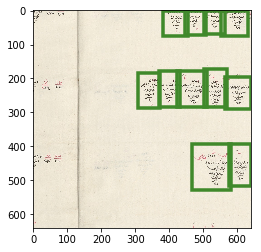

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from gluoncv.utils import viz
ax = viz.plot_bbox(img.asnumpy(), bbox)
plt.show()